In [ ]:
# !pip uninstall dgl
# !pip install dgl -f https://data.dgl.ai/wheels/repo.html
!pip install dgl
!pip install torch==2.1.2

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 670.2/670.2 MB 614.4 kB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 209.8/209.8 MB 4.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 89.2/89.2 MB 6.1 MB/s eta 0:00:00
  Attempting uninstall: triton
    Found existing installation: triton 2.3.0
    Uninstalling triton-2.3.0:
      Successfully uninstalled triton-2.3.0
  Attempting uninstall: nvidia-nccl-cu12
    Found existing installation: nvidia-nccl-cu12 2.20.5
    Uninstalling nvidia-nccl-cu12-2.20.5:
      Successfully uninstalled nvidia-nccl-cu12-2.20.5
  Attempting uninstall: torch
    Found existing installation: torch 2.3.0+cu121
    Uninstalling torch-2.3.0+cu121:
      Successfully uninstalled torch-2.3.0+cu121
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
torchaudio 2.3.0+cu121 requires torch==2.3.0, but you have torch 2

In [ ]:
from tqdm import tqdm
import pandas as pd
import numpy as np
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.cluster import SpectralClustering
from sklearn.metrics.pairwise import cosine_similarity
import networkx as nx
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

from gensim.test.utils import common_texts
from gensim.models import Word2Vec
from transformers import BertTokenizer, BertModel
from transformers import RobertaTokenizer, RobertaModel

import dgl
import dgl.nn as dglnn
from dgl.nn import HeteroGraphConv
from dgl.nn import HeteroEmbedding

In [ ]:
# !unzip '/content/drive/MyDrive/Учеба/Курсач/ml-latest (1).zip' -d '/content/drive/MyDrive/Учеба/Курсач/'

# Построение рекомендательной системы с помощью векторного представления графа

## Идея
Эвристика: если по эмбеддингу пользователя и признакам фильма можно хорошо предсказать оценку, то  такой эмбеддинг является качественной репрезентацией пользователя.\
После получения эмбеддингов кластеризуем всех пользователей и будем рекомендовать пользователю фильмы, которые понравились другим пользователям из его кластера. Таким образом, база фильмов, которые потенциально могут понравиться зрителям из этого кластера, будет постоянно пополняться.


## План
1. Построить гетерогенный граф (типы узлов: фильмы и пользователи);
2. Добавить признаки фильмов;
3. Решая задачу прогнозирования оценки фильма конкретным пользователем, получить эмбеддинги всех юзеров;
4. Кластеризовать пользователей.


# Movie processing

In [ ]:
def check_id_type(idx):
  try:
    int_id = int(idx)
    return True
  except:
    return False

In [ ]:
links = pd.read_csv('/content/drive/MyDrive/Учеба/Курсач/ml-latest-small/links.csv').dropna()
links['tmdbId'] = links['tmdbId'].astype(int)
links.head()

,movieId,imdbId,tmdbId
0,1,114709,862
1,2,113497,8844
2,3,113228,15602
3,4,114885,31357
4,5,113041,11862


In [ ]:
movies = pd.read_csv('/content/drive/MyDrive/Учеба/Курсач/ml-latest-small/movies.csv')
movies['title'] = movies['title'].apply(lambda x: x.split(' (')[0])
movies['genres'] = movies['genres'].apply(lambda x: ', '.join(x.lower().split('|')))
movies = pd.merge(movies, links[['movieId', 'tmdbId']], on='movieId')
movies.head()

,movieId,title,genres,tmdbId
0,1,Toy Story,"adventure, animation, children, comedy, fantasy",862
1,2,Jumanji,"adventure, children, fantasy",8844
2,3,Grumpier Old Men,"comedy, romance",15602
3,4,Waiting to Exhale,"comedy, drama, romance",31357
4,5,Father of the Bride Part II,comedy,11862


In [ ]:
movies['movieId'].max()

193609

In [ ]:
movies.shape

(9734, 4)

### movies nodes

In [ ]:
meta = pd.read_csv('/content/drive/MyDrive/Учеба/Курсач/ml-latest-small/movies_metadata.csv')
meta = meta[meta['id'].apply(check_id_type)][['id', 'title', 'overview', 'popularity']]
meta['id'] = meta['id'].astype(int)
meta.head()

<ipython-input-8-b31e44caba14>:1: DtypeWarning: Columns (10) have mixed types. Specify dtype option on import or set low_memory=False.
  meta = pd.read_csv('/content/drive/MyDrive/Учеба/Курсач/ml-latest-small/movies_metadata.csv')


,id,title,overview,popularity
0,862,Toy Story,"Led by Woody, Andy's toys live happily in his ...",21.946943
1,8844,Jumanji,When siblings Judy and Peter discover an encha...,17.015539
2,15602,Grumpier Old Men,A family wedding reignites the ancient feud be...,11.7129
3,31357,Waiting to Exhale,"Cheated on, mistreated and stepped on, the wom...",3.859495
4,11862,Father of the Bride Part II,Just when George Banks has recovered from his ...,8.387519


In [ ]:
movie_nodes = pd.merge(movies, meta, left_on='tmdbId', right_on='id').dropna(subset=['overview'])
movie_nodes = movie_nodes[~movie_nodes['movieId'].duplicated()]
movie_nodes = movie_nodes.rename(columns={'title_y': 'title'}).drop(['title_x', 'id', 'tmdbId'], axis=1)
movie_nodes = movie_nodes[['movieId', 'title', 'genres', 'overview', 'popularity']]

scaler = StandardScaler()
movie_nodes['popularity'] = scaler.fit_transform(movie_nodes[['popularity']])

movie_nodes['title'] = movie_nodes['title'].apply(lambda x: x.lower())
movie_nodes['overview'] = movie_nodes['overview'].apply(lambda x: x.lower())

movie_genres_nodes = movie_nodes.copy()
movie_genres_nodes['genres'] = movie_genres_nodes['genres'].apply(lambda x: x.split(', '))
movie_genres_nodes = movie_genres_nodes.explode('genres')

movie_nodes.head()

,movieId,title,genres,overview,popularity
0,1,toy story,"adventure, animation, children, comedy, fantasy","led by woody, andy's toys live happily in his ...",1.312452
1,2,jumanji,"adventure, children, fantasy",when siblings judy and peter discover an encha...,0.859382
2,3,grumpier old men,"comedy, romance",a family wedding reignites the ancient feud be...,0.372205
3,4,waiting to exhale,"comedy, drama, romance","cheated on, mistreated and stepped on, the wom...",-0.349322
4,5,father of the bride part ii,comedy,just when george banks has recovered from his ...,0.066688


In [ ]:
movie_nodes.shape

(9526, 5)

In [ ]:
movie_nodes.isna().sum()

movieId       0
title         0
genres        0
overview      0
popularity    0
dtype: int64

In [ ]:
ratings = pd.read_csv('/content/drive/MyDrive/Учеба/Курсач/ml-latest/ratings.csv').drop('timestamp', axis=1)
ratings = ratings[ratings['movieId'].isin(set(movie_nodes['movieId'].unique()))].iloc[:1_000_000]
ratings

,userId,movieId,rating
0,1,1,4.0
1,1,110,4.0
2,1,158,4.0
3,1,260,4.5
4,1,356,5.0
...,...,...,...
1072435,10262,1,4.0
1072436,10262,3,2.0
1072437,10262,21,4.0
1072438,10262,25,3.0


In [ ]:
ratings['movieId'].max(), ratings['userId'].nunique()

(175743, 10226)

### Movie features

#### overview

In [ ]:
torch.manual_seed(0)

In [ ]:
# Загрузка предобученного токенизатора и модели RoBERTa
tokenizer = RobertaTokenizer.from_pretrained("roberta-base")
model = RobertaModel.from_pretrained("roberta-base")

# Функция для получения эмбеддинга всего текста
def get_text_embedding(text):
    # Токенизация текста и добавление токенов начала и конца последовательности
    inputs = tokenizer(text, return_tensors="pt", padding=True, truncation=True)
    # Получение выхода последнего слоя RoBERTa
    with torch.no_grad():
        outputs = model(**inputs)
        text_embedding = outputs.last_hidden_state.mean(dim=1)  # Усреднение эмбеддингов всех токенов
    return text_embedding

# Пример использования
text = ["Пример текста для получения эмбеддинга.", "brfkm srbkm sr;bmk"]
target_dim = 128  # Новая размерность эмбеддинга
embedding = get_text_embedding(text)
print(embedding.size())  # Размерность нового эмбеддинга

/usr/local/lib/python3.10/dist-packages/huggingface_hub/utils/_token.py:89: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/25.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

/usr/local/lib/python3.10/dist-packages/huggingface_hub/file_download.py:1132: FutureWarning: `resume_download` is deprecated and will be removed in version 1.0.0. Downloads always resume when possible. If you want to force a new download, use `force_download=True`.
  warnings.warn(


config.json:   0%|          | 0.00/481 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/499M [00:00<?, ?B/s]

Some weights of RobertaModel were not initialized from the model checkpoint at roberta-base and are newly initialized: ['roberta.pooler.dense.bias', 'roberta.pooler.dense.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


torch.Size([2, 768])


In [ ]:
# torch.manual_seed(0)
# succes_i = []
# bsize = 10

# for i in tqdm(range(0,len(movie_nodes['overview'].tolist()),bsize)):
#   sample = movie_nodes['overview'].iloc[i:i+bsize].tolist()
#   overview_embeddings = movie_nodes['overview'].iloc[i:i+bsize].apply(get_text_embedding)
#   overview_embeddings = torch.cat(overview_embeddings.tolist())
#   torch.save(overview_embeddings, f'/content/drive/MyDrive/Учеба/Курсач/movie_features/overview_embeddings_{i}.pt')
#   succes_i.append(i)

100%|██████████| 953/953 [59:11<00:00,  3.73s/it]


59m 11s

In [ ]:
base_path = '/content/drive/MyDrive/Учеба/Курсач/movie_features/'

# movie_features = []
movie_features_batch = []
for i in tqdm(range(0, 9526, 10)):
  path = base_path + f'overview_embeddings_{i}.pt'
  movie_features_batch.append(torch.load(path))

100%|██████████| 953/953 [04:43<00:00,  3.37it/s]


In [ ]:
movie_features = torch.cat(movie_features_batch)
movie_features.shape

torch.Size([9526, 768])

#### genres

In [ ]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder


encoder = OneHotEncoder()

# Преобразование жанров в One-Hot Encoding (в данных всего 20 жанров)
encoded_features = encoder.fit_transform(movie_genres_nodes[['genres']]).toarray()

genre_feats = [f'genre_feat_{i}' for i in range(20)]
movie_genres_nodes[genre_feats] = encoded_features
movie_genres_nodes = movie_genres_nodes.groupby('movieId')[genre_feats].sum()
movie_nodes[genre_feats] = movie_genres_nodes[genre_feats].values

overview_feats = [f'overview_feat_{i}' for i in range(movie_features.shape[1])]
movie_nodes[overview_feats] = movie_features.numpy()
movie_nodes

<ipython-input-19-42283556a93c>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movie_nodes[overview_feats] = movie_features.numpy()
<ipython-input-19-42283556a93c>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  movie_nodes[overview_feats] = movie_features.numpy()
<ipython-input-19-42283556a93c>:15: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de

,movieId,title,genres,overview,popularity,genre_feat_0,genre_feat_1,genre_feat_2,genre_feat_3,genre_feat_4,...,overview_feat_758,overview_feat_759,overview_feat_760,overview_feat_761,overview_feat_762,overview_feat_763,overview_feat_764,overview_feat_765,overview_feat_766,overview_feat_767
0,1,toy story,"adventure, animation, children, comedy, fantasy","led by woody, andy's toys live happily in his ...",1.312452,0.0,0.0,1.0,1.0,1.0,...,-0.118395,0.026442,-0.074256,0.015184,0.011428,0.128188,0.056751,-0.372938,0.099065,-0.084081
1,2,jumanji,"adventure, children, fantasy",when siblings judy and peter discover an encha...,0.859382,0.0,0.0,1.0,0.0,1.0,...,-0.072616,0.092617,-0.088102,-0.048294,0.046545,0.143418,-0.145145,-0.066125,0.023434,-0.025923
2,3,grumpier old men,"comedy, romance",a family wedding reignites the ancient feud be...,0.372205,0.0,0.0,0.0,0.0,0.0,...,-0.008188,0.012191,-0.072301,0.002425,0.024805,0.101415,-0.100844,-0.129523,0.081770,0.058399
3,4,waiting to exhale,"comedy, drama, romance","cheated on, mistreated and stepped on, the wom...",-0.349322,0.0,0.0,0.0,0.0,0.0,...,-0.050615,0.008420,0.134794,-0.002123,-0.100271,0.094565,-0.043027,-0.106231,0.022619,0.020725
4,5,father of the bride part ii,comedy,just when george banks has recovered from his ...,0.066688,0.0,0.0,0.0,0.0,0.0,...,-0.059836,0.032970,-0.077837,0.014599,0.009678,0.135186,0.028604,-0.279000,0.059329,0.098375
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9550,175705,themroc,"comedy, horror","made without proper language, just gibberish a...",-0.518424,0.0,0.0,0.0,0.0,0.0,...,-0.188864,0.030558,0.007318,-0.117035,-0.031262,0.102785,0.058469,-0.000337,0.017734,0.038972
9551,175707,a german life,documentary,"brunhilde pomsel describes herself as an ""apol...",-0.692329,0.0,0.0,0.0,0.0,0.0,...,-0.043569,-0.001627,0.020204,0.037133,0.046007,0.141687,0.077362,-0.140436,0.019038,0.114710
9552,175743,self-criticism of a bourgeois dog,comedy,a bourgeois dog confesses how he was transform...,-0.696637,0.0,0.0,0.0,0.0,0.0,...,-0.081541,0.058010,-0.067532,-0.116918,-0.016774,0.056207,0.001510,-0.144688,-0.004600,0.021337
9553,175781,der herr karl,comedy,no overview found.,-0.686249,0.0,0.0,0.0,0.0,0.0,...,-0.005689,-0.072258,-0.117620,-0.026552,-0.053096,0.078182,0.220623,0.032055,-0.039045,-0.023568


### create dgl graph

In [ ]:
ratings.sample(5)

,userId,movieId,rating
364108,3598,318,3.0
971077,9298,1876,2.0
226953,2327,168250,5.0
237742,2402,1059,3.5
752810,7181,1032,3.0


In [ ]:
# отберем пользователей посмотревших не менее 100 фильмов
cnts = ratings['userId'].value_counts()
selected_users = set(cnts[cnts >= 100].index)

ratings = ratings[ratings['userId'].isin(selected_users)].reset_index(drop=True)
userId_mapping = dict(zip(ratings['userId'].unique(), range(ratings['userId'].nunique())))
ratings['userId'] = ratings['userId'].map(userId_mapping)

selected_movies = set(ratings['movieId'])
movie_nodes = movie_nodes[movie_nodes['movieId'].isin(selected_movies)].reset_index(drop=True)
movieId_mapping = dict(zip(movie_nodes['movieId'].unique(), range(movie_nodes['movieId'].nunique())))
movie_nodes['movieId'] = movie_nodes['movieId'].map(movieId_mapping)
ratings['movieId'] = ratings['movieId'].map(movieId_mapping)

ratings

,userId,movieId,rating
0,0,0,4.0
1,0,2,3.0
2,0,10,5.0
3,0,20,2.0
4,0,24,3.0
...,...,...,...
781515,2520,4267,4.0
781516,2520,4268,4.0
781517,2520,4275,5.0
781518,2520,4290,4.0


In [ ]:
ratings['userId'].nunique(), ratings['movieId'].nunique(), movie_nodes['movieId'].nunique()

(2521, 8824, 8824)

In [ ]:
movie_nodes.iloc[:, 4:].shape

(8824, 789)

In [ ]:
graph_data = {
    ('user', 'rated', 'movie'): (torch.tensor(ratings['userId'].values), torch.tensor(ratings['movieId'].values)),
    ('movie', 'rated-by', 'user'): (torch.tensor(ratings['movieId'].values), torch.tensor(ratings['userId'].values))
}
g = dgl.heterograph(graph_data)

target_ratings = torch.tensor(ratings[['rating']].values, dtype=torch.float)

user_ids, movie_ids = g.edges(etype='rated')
n_el = user_ids.shape[0]

while True:
  train_ids = np.random.choice(np.arange(n_el), size=int(n_el*0.8), replace=False)
  test_ids = torch.tensor(list(set(np.arange(n_el)) - set(train_ids))).long()
  train_ids = torch.tensor(train_ids).long()
  if not set(user_ids[test_ids].tolist()) - set(user_ids[train_ids].tolist()):
    break

train_ids.shape, test_ids.shape

(torch.Size([625216]), torch.Size([156304]))

### create graph embedding

In [ ]:
torch.manual_seed(0)

class RatingPredictionModel(nn.Module):
    def __init__(self, movie_feat_dim, hidden_feats, user_feat_dim, output_dim):
        super(RatingPredictionModel, self).__init__()
        self.user_embedding = HeteroEmbedding({'user': g.number_of_nodes('user')}, user_feat_dim)
        self.conv1 = HeteroGraphConv({
            ('user', 'rated', 'movie'):  dglnn.GraphConv(user_feat_dim, hidden_feats),
            ('movie', 'rated-by', 'user'):  dglnn.GraphConv(movie_feat_dim, hidden_feats)
        }, aggregate='sum')
        self.conv2 = HeteroGraphConv({
            ('user', 'rated', 'movie'): dglnn.GraphConv(hidden_feats, output_dim),
            ('movie', 'rated-by', 'user'): dglnn.GraphConv(hidden_feats, output_dim)
        }, aggregate='sum')
        self.fc1 = nn.Linear(2*output_dim, 2*output_dim)
        self.fc2 = nn.Linear(2*output_dim, 10)


    def forward(self, g, movie_feats, ids):
        user_embeds = self.user_embedding({'user': g.nodes('user')})
        h = self.conv1(g, {'movie': movie_feats, 'user': user_embeds['user']})
        h = {k: torch.relu(v) for k, v in h.items()}
        h = self.conv2(g, h)

        user_ids, movie_ids = g.edges(etype='rated')
        user_ids, movie_ids = user_ids[ids], movie_ids[ids]
        output = torch.relu(self.fc1(torch.cat([h['user'][user_ids], h['movie'][movie_ids]], axis=1)))
        output = self.fc2(output)
        return output


movie_feats = torch.tensor(movie_nodes.iloc[:,4:].values, dtype=torch.float)
movie_feat_dim = movie_feats.shape[1]
hidden_feats = 128
user_feat_dim = 256
ouptut_dim = 256

model = RatingPredictionModel(movie_feat_dim, hidden_feats, user_feat_dim, ouptut_dim)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=0.001)

train_loss = []
test_loss = []
num_epochs = 100
for epoch in range(num_epochs):
    model.train()
    optimizer.zero_grad()
    user_ratings_pred = model(g, movie_feats, train_ids)
    loss = criterion(user_ratings_pred, target_ratings[train_ids])
    loss.backward()
    optimizer.step()
    train_loss.append(loss.item())

    if epoch % 10 == 0:
      model.eval()
      user_ratings_pred = model(g, movie_feats, test_ids)
      loss = criterion(user_ratings_pred, target_ratings[test_ids])
      print(f'Epoch [{epoch+1}/{num_epochs}], Val loss: {loss.item():.4f}')
      test_loss.append(loss.item())

Epoch [1/100], Val loss: 11.1721
Epoch [11/100], Val loss: 3.1734
Epoch [21/100], Val loss: 2.3136
Epoch [31/100], Val loss: 1.9853
Epoch [41/100], Val loss: 1.8206
Epoch [51/100], Val loss: 1.7194
Epoch [61/100], Val loss: 1.6381
Epoch [71/100], Val loss: 1.5764
Epoch [81/100], Val loss: 1.5201
Epoch [91/100], Val loss: 1.4683


In [ ]:
model.eval()
user_ratings_pred = model(g, movie_feats, test_ids)
loss = criterion(user_ratings_pred, target_ratings[test_ids])

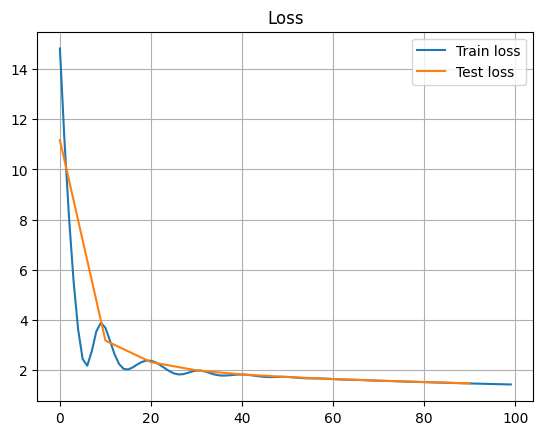

In [ ]:
plt.plot(range(len(train_loss)), train_loss, label='Train loss')
plt.plot(range(0,len(train_loss),10), test_loss, label='Test loss')
plt.legend()
plt.title('Loss')
plt.grid()

In [ ]:
epoch

99

### Эмбеддинги

In [ ]:
# user_embeddings = model.user_embedding({'user': g.nodes('user')})['user']
# torch.save(user_embeddings, f'/content/drive/MyDrive/Учеба/Курсач/user_embeddings_99_correct.pt')
user_embeddings = torch.load('/content/drive/MyDrive/Учеба/Курсач/user_embeddings_99_correct.pt')
user_embeddings.shape

torch.Size([2521, 256])

In [ ]:
np.linalg.norm(A, axis=1).shape

(2521,)

# Рекомендательная система

In [ ]:
def get_recommendation(user_id, cos_sim_matrix, ratings, test_ids, n_user_for_rec=3, num_to_rec=20, plot=False):
  most_similar_users = cos_sim_matrix[user_id].argsort()
  ratings_test = ratings.iloc[test_ids]

  subset_user = ratings[ratings['userId'] == user_id]
  subset_user_test = ratings_test[ratings_test['userId'] == user_id] # фильмы юзера, попавшие в тест (для метрик)
  subset_predictors = ratings[ratings['userId'].isin(set(most_similar_users[-2-n_user_for_rec:-1]))] # фильмы похожих пользователей
  agg_predictors = subset_predictors.groupby('movieId', as_index=False).agg({'rating': 'mean'})

  # выбираем наиболее понравившиеся n фильмов
  not_seen_movies = set(agg_predictors['movieId']) - set(subset_user['movieId'])
  rec = agg_predictors.sort_values('rating', ascending=False).head(num_to_rec)

  merged = pd.merge(subset_user_test, agg_predictors, on='movieId')
  acc = ((merged['rating_x']>3) & (merged['rating_y']>3) | (merged['rating_x']<=3) & (merged['rating_y']<=3)).mean()
  mae = abs(merged['rating_x'] - merged['rating_y']).mean()
  if plot:
    merged[['rating_x', 'rating_y']].plot()
    plt.title(f'userId = {user_id}, согл. = {round(acc, 3)}, spearmanr = {round(spearmanr(merged["rating_x"], merged["rating_y"])[0], 3)}')
    plt.grid()
  return (merged.shape[0], acc, mae, rec)

In [ ]:
cos_sim_matrix = np.abs(cosine_similarity(A))
cos_sim_matrix.shape

(2521, 2521)

In [ ]:
accs = []
for n in [5, 10, 15]:
  for i in ratings['userId'].unique():
    res = get_recommendation(i, cos_sim_matrix, ratings, test_ids, n_user_for_rec=n)
    accs.append(res[1])
  arr = np.array(accs)
  arr = arr[~np.isnan(arr)]
  print(f'Кол-во похожих пользователей: {n}')
  print(f'Средняя согласованность в мнении по фильмам = {arr.mean()}')
  print('---------------------------------------------------------------------')

Кол-во похожих пользователей: 5
Средняя согласованность в мнении по фильмам = 0.6381506777755553
---------------------------------------------------------------------
Кол-во похожих пользователей: 10
Средняя согласованность в мнении по фильмам = 0.6429115185113289
---------------------------------------------------------------------
Кол-во похожих пользователей: 15
Средняя согласованность в мнении по фильмам = 0.6464278856218092
---------------------------------------------------------------------


In [ ]:
maes = []
for n in [5, 10, 15]:
  for i in ratings['userId'].unique():
    res = get_recommendation(i, cos_sim_matrix, ratings, test_ids, n_user_for_rec=n)
    maes.append(res[2])
  arr = np.array(maes)
  arr = arr[~np.isnan(arr)]
  print(f'Кол-во похожих пользователей: {n}')
  print(f'Средняя метрика MAE = {arr.mean()}')
  print('---------------------------------------------------------------------')

Кол-во похожих пользователей: 5
Средняя метрика MAE = 0.9471298460175899
---------------------------------------------------------------------
Кол-во похожих пользователей: 10
Средняя метрика MAE = 0.9296510041525379
---------------------------------------------------------------------
Кол-во похожих пользователей: 15
Средняя метрика MAE = 0.9155910493838899
---------------------------------------------------------------------


In [ ]:
abs(ratings['rating'] - ratings['rating'].mean()).mean()

1.3156454089466685

In [ ]:
# accs = []
# for n in [20, 30, 45]:
#   for i in ratings['userId'].unique():
#     res = get_recommendation(i, cos_sim_matrix, ratings, test_ids, n_user_for_rec=n)
#     accs.append(res[1])
#   arr = np.array(accs)
#   arr = arr[~np.isnan(arr)]
#   print(f'Кол-во похожих пользователей: {n}')
#   print(f'Средняя согласованность в мнении по фильмам = {arr.mean()}')
#   print('---------------------------------------------------------------------')

In [ ]:
for n in [20, 30, 45]:
  weight_sum = 0
  acc = 0
  for i in ratings['userId'].unique():
    res = get_recommendation(i, cos_sim_matrix, ratings, test_ids, n_user_for_rec=n)
    if not np.isnan(res[1]):
      weight_sum += res[0]
      acc += res[0] * res[1]
  print(f'Кол-во похожих пользователей: {n}')
  print(f'Средняя согласованность в мнении по фильмам = {acc / weight_sum}')
  print('---------------------------------------------------------------------')

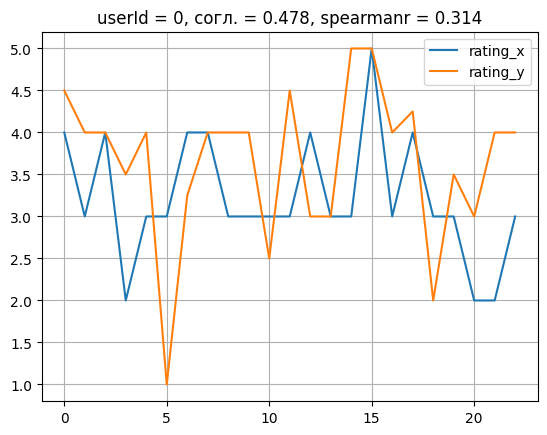

In [ ]:
res = get_recommendation(0, cos_sim_matrix, ratings, test_ids, n_user_for_rec=1, plot=True)

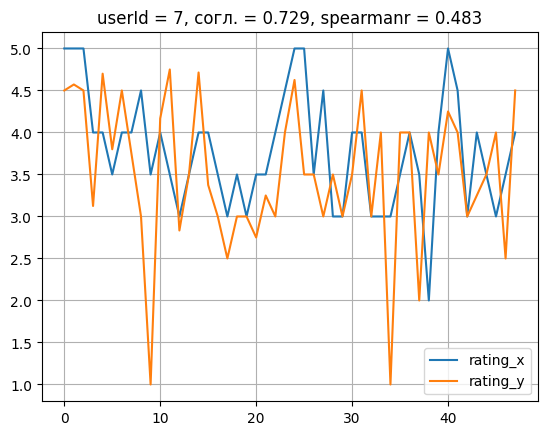

In [ ]:
res = get_recommendation(7, cos_sim_matrix, ratings, test_ids, n_user_for_rec=10, plot=True)

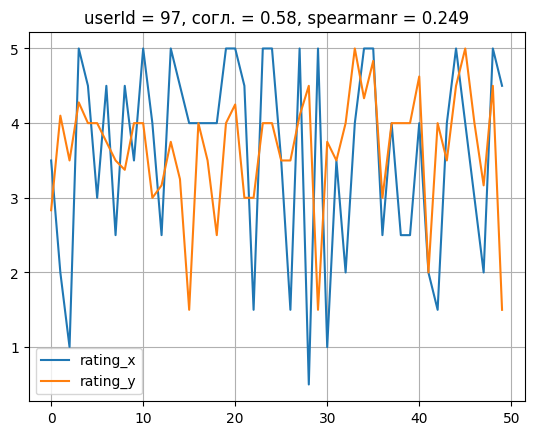

In [ ]:
res = get_recommendation(97, cos_sim_matrix, ratings, test_ids, n_user_for_rec=10, plot=True)